**U-NET 4 bands**

Dataset

In [1]:
import sys
sys.path.append("..")
sys.path.append("..")

from src import dataset_4bands as dataset
from src import metadata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader

from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
import time

from torchsummary import summary

import optuna

In [2]:
df_s2 = metadata.process_metadata("/media/disk/databases/cloudsen12/high/hq_data.csv")

df_s2 = df_s2.reset_index()
df_s2

,index,user,ROI,sen2,cloud_per,cloud_coverage,sensing_time,year,path
0,0,ANDREA,point_0317,20190207T172509_20190207T173213_T13QGG,0.0,cloud-free,2019-02-07 17:25:09+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
1,5,ANDREA,point_0320,20190409T164849_20190409T165500_T16UGD,0.0,cloud-free,2019-04-09 16:48:49+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
2,10,ANDREA,point_0323,20200407T222531_20200407T222530_T04WDS,0.0,cloud-free,2020-04-07 22:25:31+00:00,2020,/media/disk/databases/cloudsen12/high/point_03...
3,15,ANDREA,point_0329,20190114T101351_20190114T102032_T31PDP,0.0,cloud-free,2019-01-14 10:13:51+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
4,20,ANDREA,point_0332,20190127T070141_20190127T071456_T39NTJ,0.0,cloud-free,2019-01-27 07:01:41+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
...,...,...,...,...,...,...,...,...,...
1995,9975,WENDY,point_9969,20190327T054641_20190327T055021_T43RCQ,0.0,cloud-free,2019-03-27 05:46:41+00:00,2019,/media/disk/databases/cloudsen12/high/point_99...
1996,9980,WENDY,point_9976,20181217T055231_20181217T055231_T43SDR,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/high/point_99...
1997,9985,WENDY,point_9980,20181217T055231_20181217T055231_T42SYA,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/high/point_99...
1998,9990,WENDY,point_9981,20181217T055231_20181217T055231_T42SYA,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/high/point_99...


In [3]:
df_pv = metadata.process_metadata("/media/disk/databases/cloudsen12/highprobav/processed_probav.csv")
df_pv

,ROI,user,sen2,cloud_per,cloud_coverage,sensing_time,year,path,bounds_latlong,bounds,crs_chips,geometry,center_latlong,PV100TOC,PV100TOA,PV_diff_days,PV_frac_invalids,PV_frac_clouds,missing
0,point_0317,ANDREA,20190207T172509_20190207T173213_T13QGG,0.0,cloud-free,2019-02-07 17:25:09+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(-102.33019815388593, 24.313454163761712, -102...","BoundingBox(left=770950.0, bottom=2691630.0, r...",EPSG:32613,POLYGON ((-102.33019815388593 24.3134541637617...,"(-102.30465226392862, 24.336860226798464)",PROBAV_S1_TOC_X07Y05_20190209_100M_V101.HDF5,PROBAV_S1_TOA_X07Y05_20190209_100M_V101.HDF5,2.0,0.000000,0.157719,False
1,point_0320,ANDREA,20190409T164849_20190409T165500_T16UGD,0.0,cloud-free,2019-04-09 16:48:49+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(-83.8758104013502, 52.4839623391974, -83.7976...","BoundingBox(left=712120.0, bottom=5819680.0, r...",EPSG:32616,"POLYGON ((-83.8758104013502 52.4839623391974, ...","(-83.83672824372164, 52.50780920150713)",PROBAV_S1_TOC_X09Y02_20190410_100M_V101.HDF5,PROBAV_S1_TOA_X09Y02_20190410_100M_V101.HDF5,1.0,0.000000,0.929783,False
2,point_0323,ANDREA,20200407T222531_20200407T222530_T04WDS,0.0,cloud-free,2020-04-07 22:25:31+00:00,2020,/media/disk/databases/cloudsen12/highprobav/po...,"(-159.79539236149657, 64.77396032968922, -159....","BoundingBox(left=462240.0, bottom=7183500.0, r...",EPSG:32604,POLYGON ((-159.79539236149657 64.7739603296892...,"(-159.74120686918297, 64.79706207184097)",PROBAV_S1_TOC_X02Y01_20200406_100M_V101.HDF5,PROBAV_S1_TOA_X02Y01_20200406_100M_V101.HDF5,-1.0,0.099609,0.900391,False
3,point_0329,ANDREA,20190114T101351_20190114T102032_T31PDP,0.0,cloud-free,2019-01-14 10:13:51+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(2.261778764637082, 12.234735220472697, 2.3087...","BoundingBox(left=419720.0, bottom=1352620.0, r...",EPSG:32631,POLYGON ((2.261778764637082 12.234735220472697...,"(2.285240232661488, 12.257809363657463)",PROBAV_S1_TOC_X18Y06_20190114_100M_V101.HDF5,PROBAV_S1_TOA_X18Y06_20190114_100M_V101.HDF5,0.0,0.000000,0.000000,False
4,point_0332,ANDREA,20190127T070141_20190127T071456_T39NTJ,0.0,cloud-free,2019-01-27 07:01:41+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(48.77810415711981, 7.734263085540499, 48.8244...","BoundingBox(left=254960.0, bottom=855560.0, ri...",EPSG:32639,"POLYGON ((48.77810415711981 7.734263085540499,...","(48.801287685585876, 7.757386441728896)",PROBAV_S1_TOC_X22Y06_20190127_100M_V101.HDF5,PROBAV_S1_TOA_X22Y06_20190127_100M_V101.HDF5,0.0,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,point_9969,WENDY,20190327T054641_20190327T055021_T43RCQ,0.0,cloud-free,2019-03-27 05:46:41+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(73.1428297673523, 30.83039542287769, 73.19691...","BoundingBox(left=322460.0, bottom=3412280.0, r...",EPSG:32643,"POLYGON ((73.1428297673523 30.83039542287769, ...","(73.16987025227952, 30.85372441757002)",PROBAV_S1_TOC_X25Y04_20190326_100M_V101.HDF5,PROBAV_S1_TOA_X25Y04_20190326_100M_V101.HDF5,-1.0,0.000000,0.352837,False
1996,point_9976,WENDY,20181217T055231_20181217T055231_T43SDR,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/highprobav/po...,"(74.17119907381326, 32.172166988823975, 74.225...","BoundingBox(left=421900.0, bottom=3559820.0, r...",EPSG:32643,POLYGON ((74.17119907381326 32.172166988823975...,"(74.19839903147333, 32.195295680860795)",PROBAV_S1_TOC_X25Y04_20181217_100M_V101.HDF5,PROBAV_S1_TOA_X25Y04_20181217_100M_V101.HDF5,0.0,1.000000,0.000000,False
1997,point_9980,WENDY,20181217T055231_20181217T055231_T42SYA,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/highprobav/po...,"(72.05048765833794, 31.77290206935128, 72.1057...","BoundingBox(left=788900.0, bottom=3519460.0, r...",EPSG:32642,"POLYGON ((72.05048765833794 31.77290206935128,...","(72.07809412765002, 31.79647972

In [4]:
df_s2['cloud_coverage'].unique()

array(['cloud-free'], dtype=object)

In [5]:
df_pv['cloud_coverage'].unique()

array(['cloud-free'], dtype=object)

In [6]:
df_pv.isnull().sum()

ROI                   0
user                  0
sen2                  0
cloud_per             0
cloud_coverage        0
sensing_time          0
year                  0
path                  0
bounds_latlong        0
bounds                0
crs_chips             0
geometry              0
center_latlong        0
PV100TOC            100
PV100TOA            100
PV_diff_days        100
PV_frac_invalids    119
PV_frac_clouds      119
missing               0
dtype: int64

In [7]:
np.sum(df_pv['PV100TOC'].isnull() != df_pv['PV100TOA'].isnull())

0

In [8]:
df_pv['PV_frac_clouds'].unique()

array([1.57718658e-01, 9.29782867e-01, 9.00390625e-01, ...,
       4.88601685e-01, 3.52836609e-01, 7.82012939e-04])

In [9]:
#train-test split

points = ['point_0502', 'point_0523', 'point_0537', 'point_0588', 'point_0645', 'point_0842',
               'point_0845', 'point_0882', 'point_0916', 'point_0917', 'point_0944', 'point_0983',
               'point_0992', 'point_10634', 'point_11224', 'point_11337', 'point_11588', 'point_0110',
               'point_0155', 'point_0188', 'point_0278', 'point_0322', 'point_0434', 'point_0521', 'point_0542',
               'point_0792', 'point_1302', 'point_1357', 'point_1385', 'point_1398', 'point_1771', 'point_0036',
               'point_0165', 'point_0267', 'point_0357', 'point_0399', 'point_0474', 'point_0483', 'point_0498',
               'point_0557', 'point_0562', 'point_0563', 'point_1019', 'point_1028', 'point_1043', 'point_1061',
               'point_1068', 'point_1084', 'point_1099', 'point_1124', 'point_11274', 'point_0028', 'point_0037',
               'point_0142', 'point_0214', 'point_0286', 'point_0313', 'point_0373', 'point_0487', 'point_1208',
               'point_1238', 'point_1244', 'point_1273', 'point_1276', 'point_1277', 'point_1290', 'point_1296',
               'point_11862', 'point_11920', 'point_12023', 'point_2972', 'point_3153', 'point_8099', 'point_2088',
               'point_2421', 'point_2446', 'point_2755', 'point_3400', 'point_6317', 'point_6464', 'point_6543',
               'point_6869', 'point_7355', 'point_7445', 'point_8402', 'point_9054', 'point_0800', 'point_0812',
               'point_0820', 'point_0822', 'point_0823', 'point_4211', 'point_4325', 'point_3848', 'point_3897',
               'point_4140', 'point_4495', 'point_5786', 'point_0290', 'point_3316']

test_samples = [item in points for item in df_pv['ROI']]

df_test = df_s2[test_samples]
df_train = df_s2.loc[~df_s2.index.isin(df_test.index)]

In [10]:
print(f"Total: {df_pv.shape[0]} missing {np.sum(df_pv['missing'])}")

Total: 2000 missing 119


In [11]:
len(df_train), len(df_test)

(1900, 100)

In [12]:
any(item in df_test.index for item in df_train.index)

False

In [13]:
ds_train = dataset.TiffDataset(df_train, 256, False)
len(ds_train)

1900

1096


Text(0.5, 1.0, 'L2A')

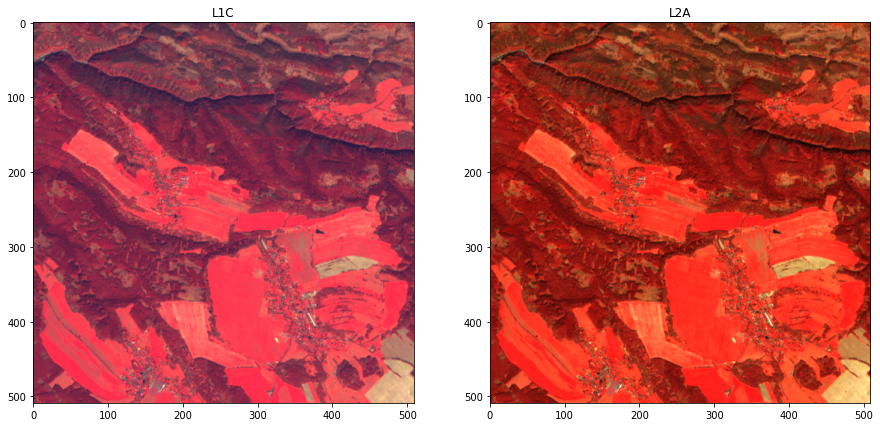

In [14]:
idx = np.random.randint(0,len(ds_train))
print(idx)
item = ds_train[idx]
item["sl1c"].shape,item["sl2a"].shape

BANDS_RGB = ["B8", "B4", "B2"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("L1C")
ax[1].imshow(rgb_l2a)
ax[1].set_title("L2A")

Models

U-NET

In [15]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, n_channels, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(n_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [17]:
model = UNet(13, 13)
summary(model, (13, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           7,552
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [18]:
#Check everything is correct

x = torch.randn((1, 4, 256, 256))
model = UNet(4, 4)
preds = model(x)
print(preds.shape)

torch.Size([1, 4, 256, 256])


Train

In [36]:
# initialize our model
model = UNet(4, 4)

#If we want to load some model weights:

#model.load_state_dict(torch.load('saved_models/model_train200_val100_e20.pth'))

# initialize loss function and optimizer
lossFunc = MSELoss()
opt = Adam(model.parameters(), lr= 0.001) 

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

# select number of epochs
num_epochs = 10


In [37]:
batch_size = 10

df_training = df_train.sample(frac=0.7)
df_val = df_train.loc[~df_train.index.isin(df_training.index)]

window = 504

trainDS = dataset.TiffDataset(df_training, window, True)
valDS = dataset.TiffDataset(df_val, window, True)

trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size)
valLoader = DataLoader(valDS, shuffle=True, batch_size=batch_size)

# calculate steps per epoch for training and test set
trainSteps = len(trainLoader)
valSteps = len(valLoader)

In [38]:
# loop over epochs
train_metrics = []
val_metrics = []

print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# loop over the training set
	for sample in trainLoader:
		# send the input to the device
		x = sample['sl1c']
		y = sample['sl2a']

		# perform a forward pass and calculate the training loss
		pred = model(x)
		train_rad_loss = lossFunc(pred, y)
		loss = train_rad_loss

		
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far
		totalTrainLoss += loss

	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()

		# loop over the validation set
		for sample in valLoader:
			# send the input to the device
			x = sample['sl1c']
			y = sample['sl2a']

			# make the predictions and calculate the validation loss
			pred = model(x)
			val_rad_loss = lossFunc(pred, y)
			totalValLoss += val_rad_loss

			

	train_rad_loss_np = train_rad_loss.cpu().detach().numpy()
	
	train_metrics.append(train_rad_loss_np)

	val_rad_loss_np = val_rad_loss.cpu().detach().numpy()

	val_metrics.append(val_rad_loss_np)
	
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
	print("Train Loss: {:.6f}, Val Loss: {:.4f}".format(avgTrainLoss, avgValLoss))
	
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


 10%|████████                                                                        | 1/10 [32:12<4:49:51, 1932.34s/it]

[INFO] EPOCH: 1/10
Train Loss: 0.010885, Val Loss: 0.0067


 20%|███████████████▌                                                              | 2/10 [1:01:18<4:03:03, 1822.94s/it]

[INFO] EPOCH: 2/10
Train Loss: 0.004204, Val Loss: 0.0026


 30%|███████████████████████▍                                                      | 3/10 [1:30:22<3:28:27, 1786.84s/it]

[INFO] EPOCH: 3/10
Train Loss: 0.003799, Val Loss: 0.0021


 40%|███████████████████████████████▏                                              | 4/10 [1:59:28<2:57:03, 1770.64s/it]

[INFO] EPOCH: 4/10
Train Loss: 0.003566, Val Loss: 0.0020


 50%|███████████████████████████████████████                                       | 5/10 [2:28:28<2:26:38, 1759.78s/it]

[INFO] EPOCH: 5/10
Train Loss: 0.003274, Val Loss: 0.0019


 60%|██████████████████████████████████████████████▊                               | 6/10 [2:57:38<1:57:04, 1756.23s/it]

[INFO] EPOCH: 6/10
Train Loss: 0.002623, Val Loss: 0.0018


 70%|██████████████████████████████████████████████████████▌                       | 7/10 [3:26:41<1:27:35, 1751.87s/it]

[INFO] EPOCH: 7/10
Train Loss: 0.002614, Val Loss: 0.0020


 80%|████████████████████████████████████████████████████████████████                | 8/10 [3:55:46<58:19, 1749.72s/it]

[INFO] EPOCH: 8/10
Train Loss: 0.003069, Val Loss: 0.0018


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [4:24:53<29:08, 1748.89s/it]

[INFO] EPOCH: 9/10
Train Loss: 0.002951, Val Loss: 0.0026


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [4:54:08<00:00, 1764.88s/it]

[INFO] EPOCH: 10/10
Train Loss: 0.002833, Val Loss: 0.0017
[INFO] total time taken to train the model: 17648.83s


Evaluate predictions

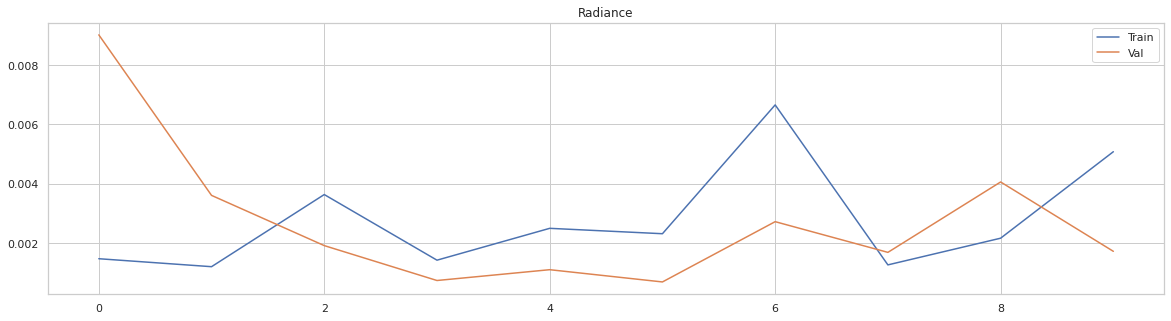

In [123]:
train_rad=[]

val_rad=[]

for i in range(num_epochs):
    train_rad.append(train_metrics[i])

    val_rad.append(val_metrics[i])
    
titles = 'Radiance'

fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.plot(train_rad, label='Train')
ax.plot(val_rad, label='Val')
ax.set_title(titles)
ax.legend()
ax.grid('True')

Global metrics

In [42]:
test = dataset.TiffDataset(df_test, 504, True)
idx = np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

loss = MSELoss()

BANDS_L2A = ["BLUE", "RED", "NIR", "SWIR"]
methods = ['RMSE', 'PSNR']
rmse_total = 0
psnr_total = 0

for j in range(len(test)):
    item = test[j]
    preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
    rmse_pred = []
    psnr_pred = []
    for i in range(len(preds[0])):
        rmse = torch.sqrt(loss(preds[0][i], item['sl2a'][i]))
        psnr = 20*torch.log10(torch.max(preds[0][i])/rmse)

        rmse_pred.append(rmse.detach().numpy())
        psnr_pred.append(psnr.detach().numpy())
    
    rmse_total += np.array(rmse_pred)
    psnr_total += np.array(psnr_pred)

RMSE = rmse_total / len(test)
PSNR = psnr_total / len(test)

pd.DataFrame(np.concatenate((RMSE,PSNR)).reshape(2,4), methods, BANDS_L2A)

,BLUE,RED,NIR,SWIR
RMSE,0.032815,0.030792,0.039380,0.023368
PSNR,23.534157,24.605696,25.112455,25.703485


Individual metrics (choose id)

In [41]:
test = dataset.TiffDataset(df_test, 504, True)
idx = np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

loss = MSELoss()
rmse_pred = []
psnr_pred = []
BANDS_L2A = ["BLUE", "RED", "NIR", "SWIR"]
methods = ['RMSE', 'PSNR']


for i in range(len(preds[0])):
    rmse = torch.sqrt(loss(preds[0][i], item['sl2a'][i]))
    psnr = 20*torch.log10(torch.max(preds[0][i])/rmse)

    rmse_pred.append(rmse.detach().numpy())
    psnr_pred.append(psnr.detach().numpy())

print('Id:', idx)
pd.DataFrame(np.concatenate((np.array(rmse_pred),np.array(psnr_pred))).reshape(2,4), methods, BANDS_L2A)

Id: 18


,BLUE,RED,NIR,SWIR
RMSE,0.012871,0.006601,0.029097,0.017903
PSNR,20.994394,24.427456,24.218645,25.011185


The following plot displays the ratio between **prediction - real value** of a series of pixels (100) from the test set images and for each band separately.

Text(0.5, 1.0, 'Sentinel-2 U-Net: Pixel ratio of predicted vs real values for the test set')

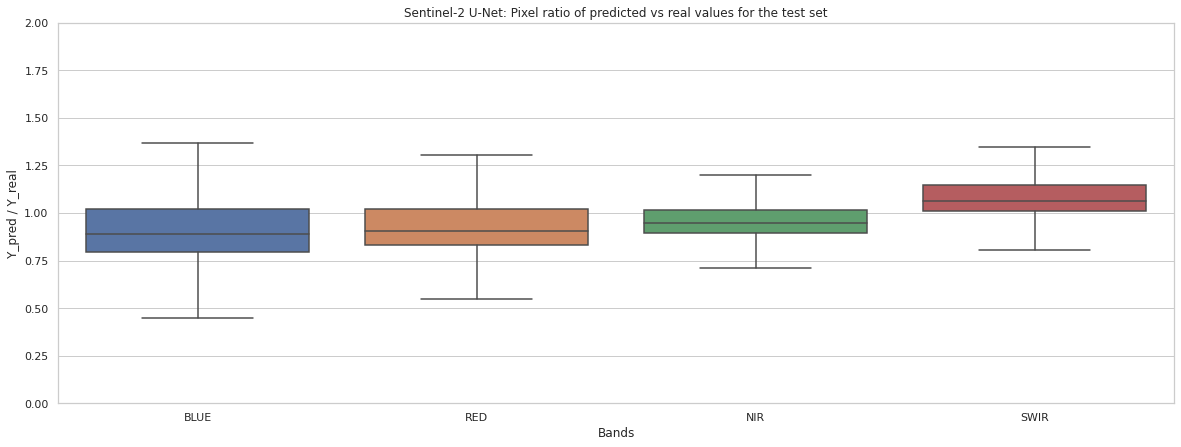

In [51]:
import seaborn as sns
boxplot = {}
boxplot["band"] = []
boxplot["val"] = []
out = np.zeros(preds.shape[1])
samples = 1000

BANDS_L2A = ["BLUE", "RED", "NIR", "SWIR"]

for sample in range(len(test)):
    test = dataset.TiffDataset(df_test, 504, True)
    #id = np.random.randint(0, len(test))
    item = test[sample]
    preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
    for sample in range(samples):
        idx = np.random.randint(0, preds.shape[2])
        idy = np.random.randint(0, preds.shape[3])
        for band in range(preds.shape[1]):
            if item['sl2a'][band][idx,idy].cpu().detach().numpy() > 0.05:
                boxplot["band"].append(BANDS_L2A[band])
                boxplot["val"].append((preds[0][band][idx,idy].cpu().detach().numpy())/(item['sl2a'][band][idx,idy].cpu().detach().numpy()))
            else:
                out[band] += 1
            


sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1,1,figsize=(20,7))

ax = sns.boxplot(x=boxplot["band"], y=boxplot["val"], order=BANDS_L2A, showfliers = False)
ax.set_xlabel('Bands')
ax.set_ylabel('Y_pred / Y_real')
ax.set(ylim=(0,2))
ax.set_title('Sentinel-2 U-Net: Pixel ratio of predicted vs real values for the test set')

In [52]:
fig.savefig("s2_unet_pixel_ratio_test_set.pdf", bbox_inches='tight')

In [53]:
out/(len(test)*samples) #Ratio of samples with real values < 0.05 for each band

array([0.56348, 0.37244, 0.04257, 0.09822])

89


Text(0.5, 1.0, 'Sentinel-2 U-Net: Pixel ratio of predicted vs real values for test image: 89')

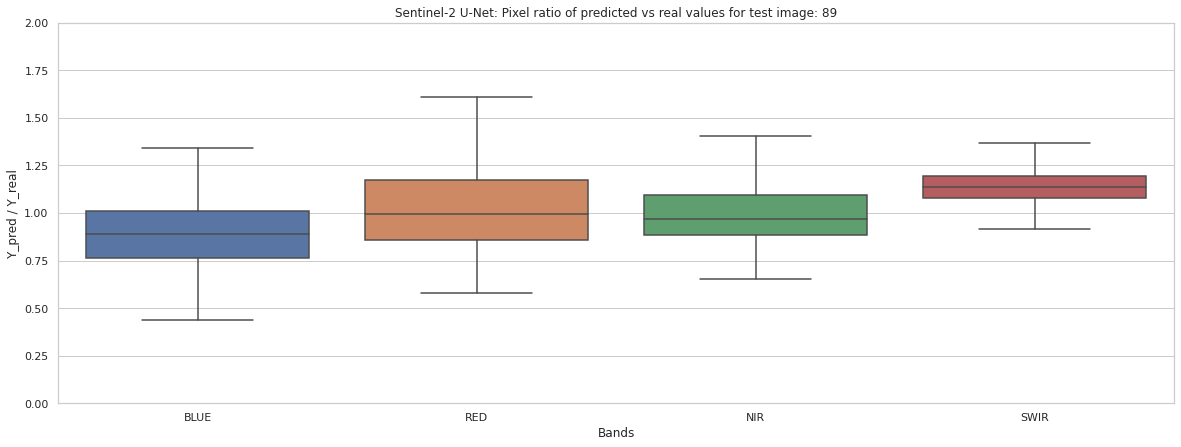

In [114]:
boxplot_2 = {}
boxplot_2["band"] = []
boxplot_2["val"] = []
out_2 = np.zeros(preds.shape[1])
samples = 1000

BANDS_L2A = ["BLUE", "RED", "NIR", "SWIR"]

test = dataset.TiffDataset(df_test, 504, True)
idn = 89 #89np.random.randint(0, len(test))
print(idn)
item = test[idn]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

for sample in range(samples):
    idx = np.random.randint(0, preds.shape[2])
    idy = np.random.randint(0, preds.shape[3])
    for band in range(preds.shape[1]):
            if item['sl2a'][band][idx,idy].cpu().detach().numpy() > 0.05:
                boxplot_2["band"].append(BANDS_L2A[band])
                boxplot_2["val"].append((preds[0][band][idx,idy].cpu().detach().numpy())/(item['sl2a'][band][idx,idy].cpu().detach().numpy()))
            else:
                out_2[band] += 1
            
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1,1,figsize=(20,7))

ax = sns.boxplot(x=boxplot_2["band"], y=boxplot_2["val"], order=BANDS_L2A, showfliers = False)
ax.set_xlabel('Bands')
ax.set_ylabel('Y_pred / Y_real')
ax.set(ylim=(0,2))
ax.set_title('Sentinel-2 U-Net: Pixel ratio of predicted vs real values for test image: {}'.format(idn))

In [115]:
out_2/samples #Ratio of samples with real values < 0.05 for each band

array([0.821, 0.36 , 0.006, 0.   ])

In [116]:
fig.savefig("s2_unet_pixel_ratio_img_{}.pdf".format(idn), bbox_inches='tight')

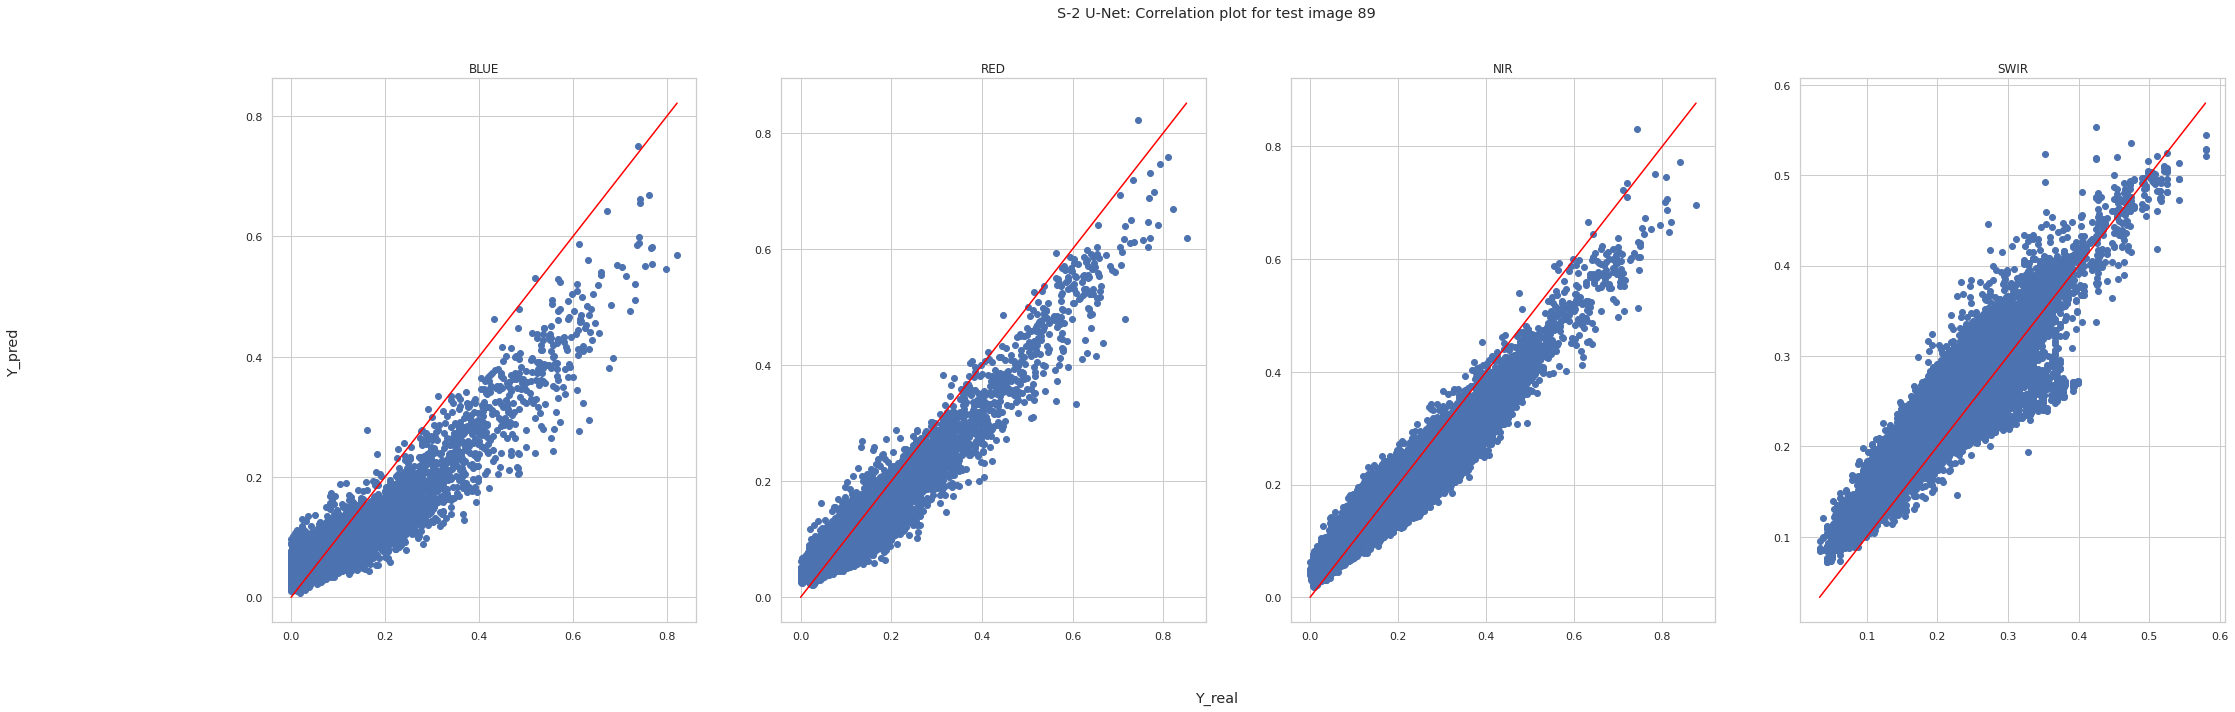

In [110]:
test = dataset.TiffDataset(df_test, 504, True)
#idn = np.random.randint(0, len(test))
item = test[idn]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
            
BANDS_L2A = ["BLUE", "RED", "NIR", "SWIR"]


fig, axs = plt.subplots(1,4,figsize=(35,10))
band=1

for band in range(len(BANDS_L2A)):
    axs[band].plot( [item['sl2a'][band].cpu().detach().numpy().min(),item['sl2a'][band].cpu().detach().numpy().max()],[item['sl2a'][band].cpu().detach().numpy().min(),item['sl2a'][band].cpu().detach().numpy().max()], c='red' )
    axs[band].scatter(item['sl2a'][band].cpu().detach().numpy(), preds[0][band].cpu().detach().numpy())
    axs[band].set_title(BANDS_L2A[band])

fig.supxlabel('Y_real')
fig.supylabel('Y_pred')
    

plt.suptitle('S-2 U-Net: Correlation plot for test image {0}'.format(idn))
plt.show()

In [111]:
fig.savefig("s2_unet_corr_img_{}.png".format(idn), dpi=50)

Plot predictions

Text(0.5, 1.0, 'Prediction')

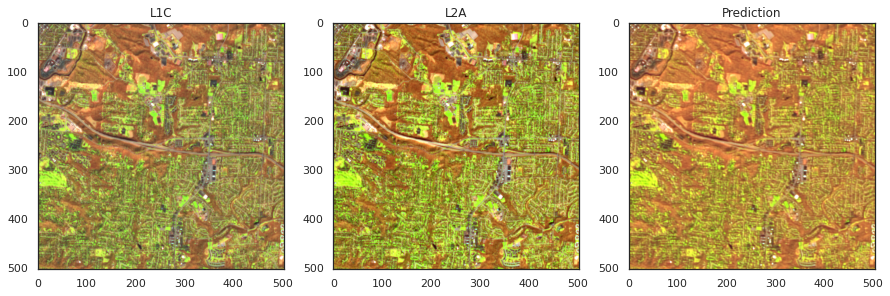

In [112]:
import seaborn as sns
sns.set_theme(style="white")

test = dataset.TiffDataset(df_test, 504, True)
idx = idn #np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

BANDS_RGB = ["B11", "B8", "B4"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

predic = preds.detach().numpy()[0][[3,2,1] ,:,:]
predic = np.clip(np.transpose(predic, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,3,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("L1C")

ax[1].imshow(rgb_l2a)
ax[1].set_title("L2A")
ax[2].imshow(predic)
ax[2].set_title("Prediction")

In [113]:
fig.savefig("plot_prediction_{}.pdf".format(idx), bbox_inches='tight')

In [39]:
#model_save = {'state_dict': model.state_dict(), 'lr': 0.001, 'alpha':0,'beta':0.2}

#torch.save(model_save, 'saved_models/unet_s2_4_bands_2.pth') 

Load previously saved model weights

In [21]:
#model.load_state_dict(torch.load('saved_models/unet_s2_4_bands.pth')['state_dict'])

<All keys matched successfully>